In [ ]:
!pip install pystan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
import stan
import pandas as pd
import numpy as np
import math
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import nest_asyncio
import arviz as az
nest_asyncio.apply()
import matplotlib.pyplot as plt


In [ ]:
# Compile the RL model
rl2_foraging_model = """
data {
  int<lower=1> N;
  int<lower=1> A;
  array[N] int<lower=0, upper=A> actions;
  array[N] int<lower=0> rewards;
}
parameters {
  real<lower=0, upper=1> alpha;
  real<lower=0> beta;
}
transformed parameters {
  real reward_scale = 200.0;  // Maximum reward value
}
model {
  vector[A] Q = rep_vector(0.0, A);

  alpha ~ normal(0,1);
  beta ~ normal(10, 5);

  for (s in 1:A) {
    Q[s] = 0;
  }

  for (t in 1:N) {
    int a = actions[t];

    vector[A] logits = beta * Q;
    real max_logit = max(logits);
    vector[A] stable_logits = logits - max_logit;
    target += stable_logits[a] - log_sum_exp(stable_logits);

    Q[a] += alpha * ((rewards[t]/reward_scale) - Q[a]);
  }
}
"""

In [ ]:
import arviz as az
import matplotlib.pyplot as plt


def plot_mcmc_convergence(fit_object, var_names=['alpha', 'beta'], subject_id=None, block_id=None):
    """
    Generates MCMC trace plots matching the example image style.

    Args:
        fit_object: The fit object returned by compiled_model.sample().
        var_names (list, optional): List of parameter names to plot/summarize.
                                    Defaults to ['alpha', 'beta'].
        subject_id (optional): Identifier for the subject for plot titles.
        block_id (optional): Identifier for the block for plot titles.
    """
    if fit_object is None:
        print("Cannot plot convergence: fit_object is None.")
        return

    # Convert to InferenceData if not already
    if not isinstance(fit_object, az.InferenceData):
        try:
            fit_object = az.convert_to_inference_data(fit_object)
        except Exception as e:
            print(f"Error converting to InferenceData: {e}")
            return

    # Create figure with subplots - one for each parameter
    n_params = len(var_names)
    fig, axes = plt.subplots(1, n_params, figsize=(4*n_params, 4), sharey=False)

    # Handle single parameter case
    if n_params == 1:
        axes = [axes]

    # Define chain colors matching the example image
    chain_colors = ['#FF7F0E', '#9467BD', '#4C2889', '#DBAF57']  # orange, purple, dark purple, light brown

    # Plot each parameter
    for i, var_name in enumerate(var_names):
        if var_name not in fit_object.posterior:
            print(f"Warning: Parameter '{var_name}' not found in fit object.")
            axes[i].text(0.5, 0.5, f"Parameter '{var_name}' not found",
                        ha='center', transform=axes[i].transAxes)
            continue

        # Get parameter data
        param_data = fit_object.posterior[var_name]

        # Handle multidimensional parameters if needed
        if len(param_data.dims) > 2:
            # For multidimensional params, just plot the first element
            if 'chain' in param_data.dims and 'draw' in param_data.dims:
                flat_dims = [d for d in param_data.dims if d not in ['chain', 'draw']]
                if flat_dims:
                    idx = {dim: 0 for dim in flat_dims}
                    param_data = param_data.isel(**idx)
            else:
                print(f"Warning: Parameter '{var_name}' doesn't have expected dimensions.")
                continue

        # Plot each chain
        for c in range(min(len(param_data.chain), 4)):
            chain_data = param_data.sel(chain=c)
            axes[i].plot(chain_data, color=chain_colors[c], linewidth=0.7, alpha=0.9)

        # Set title and labels
        axes[i].set_title(var_name)
        axes[i].set_xlabel("Iteration")

    # Add legend for chain colors
    handles = [plt.Line2D([0], [0], color=color, linewidth=1)
              for color in chain_colors[:min(len(fit_object.posterior.chain), 4)]]
    labels = [str(i+1) for i in range(min(len(fit_object.posterior.chain), 4))]

    # Place legend with "chain" title like in example
    fig.legend(handles, labels, title="chain",
              loc='upper right', bbox_to_anchor=(0.99, 0.99))

    # Set title if subject/block provided
    if subject_id is not None or block_id is not None:
        title = "MCMC Convergence"
        if subject_id is not None:
            title += f" for Subject {subject_id}"
        if block_id is not None:
            if subject_id is not None:
                title += f", Block {block_id}"
            else:
                title += f" for Block {block_id}"
        plt.suptitle(title)

    plt.tight_layout()
    plt.show()

    # Calculate and print summary statistics
    try:
        print("\nCalculating Summary Statistics (including R-hat, ESS)...")
        summary_stats = az.summary(fit_object, var_names=var_names)
        print("Summary Statistics:")
        with pd.option_context('display.max_rows', None,
                             'display.max_columns', None,
                             'display.width', 1000):
            print(summary_stats)
    except Exception as e:
        print(f"Error generating summary statistics: {e}")


In [ ]:
import pandas as pd
import numpy as np

def fit_rl2_foraging_model(df, num_chains=4, num_samples=200):
    all_samples = []
    subject_groups = df.groupby(['subno'])
    for subject, group_data in subject_groups:
        print(f"Processing Subject: {subject}")
        stan_data = {
            'N': len(group_data),
            'A': 8,
            'actions': group_data['Patch'].values.astype(int),
            'rewards': group_data['Reward'].values.astype(int)
        }
        rl2_foraging_sm = stan.build(rl2_foraging_model, data=stan_data)
        rl_fit = rl2_foraging_sm.sample(
            num_chains=num_chains,
            num_samples=num_samples
        )
        plot_mcmc_convergence(
            fit_object=rl_fit,
            subject_id=subject,
        )
        alpha = np.ravel(rl_fit['alpha'])  # flatten to 1D
        beta = np.ravel(rl_fit['beta'])    # flatten to 1D
        n_samples = len(alpha)
        samples_df = pd.DataFrame({
            'subno': [subject] * n_samples,
            'alpha': alpha,
            'beta': beta
        })
        all_samples.append(samples_df)
    return pd.concat(all_samples, ignore_index=True)


In [ ]:
# Load data
data = pd.read_csv('/content/sample_data/Foraging_data.csv')

# Convert columns safely
data['Reward'] = pd.to_numeric(data['Reward'], errors='coerce').fillna(0).astype(int)
data['subno'] = pd.to_numeric(data['subno'], errors='coerce').fillna(0).astype(int)
data['Patch'] = pd.to_numeric(data['Patch'], errors='coerce').fillna(0).astype(int)
data['Patch'] = 1 + data['Patch']

# Verify conversions
assert data['Reward'].dtype == np.int64, "Reward column must be integer type"
assert data['subno'].dtype == np.int64, "subno column must be integer type"

Processing Subject: (5,)
Building...



Building: 38.6s, done.Sampling:   0%
Sampling:   0% (1/20000)
Sampling:   1% (101/20000)
Sampling:   2% (500/20000)
Sampling:   4% (700/20000)
Sampling:   5% (1000/20000)
Sampling:   6% (1200/20000)
Sampling:  12% (2500/20000)
Sampling:  35% (7000/20000)
Sampling:  60% (12000/20000)
Sampling:  85% (17000/20000)
Sampling: 100% (20000/20000)
Sampling: 100% (20000/20000), done.
Messages received during sampling:
  Gradient evaluation took 0.000563 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.63 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000518 seconds
  1000 transitions using 10 leapfrog steps per transition would take 5.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000168 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.68 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000217 seconds
  1000 transitions using 10 leapfrog step

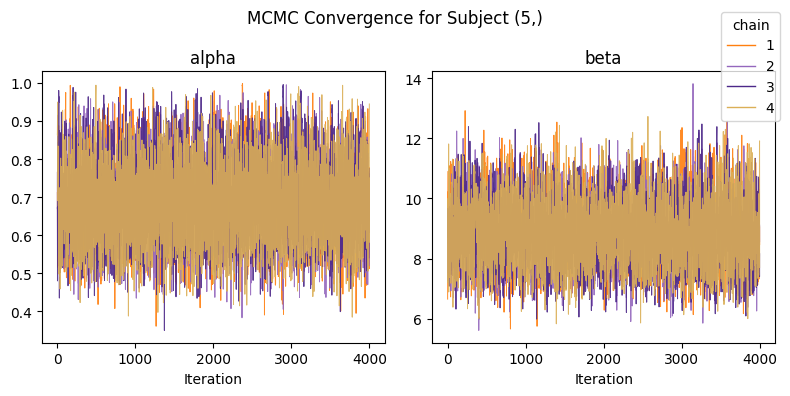


Calculating Summary Statistics (including R-hat, ESS)...
Summary Statistics:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
alpha  0.693  0.104   0.511    0.900      0.001    0.001    7530.0    4370.0    1.0
beta   8.870  1.046   6.913   10.835      0.012    0.009    7185.0    8671.0    1.0


In [ ]:
data = data[data['subno']==5]
results_df = fit_rl2_foraging_model(data,4,4000)

In [ ]:
results_df

,subno,alpha,beta
0,"(5,)",0.712015,6.654621
1,"(5,)",0.670497,9.121649
2,"(5,)",0.672183,9.655876
3,"(5,)",0.863768,9.838732
4,"(5,)",0.683321,8.827831
...,...,...,...
15995,"(5,)",0.726498,11.914030
15996,"(5,)",0.705787,8.470572
15997,"(5,)",0.693883,9.111493
15998,"(5,)",0.775198,8.162909


#MLE Calculation

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import math

alpha = results_df['alpha']
beta = results_df['beta']
samples = np.vstack([alpha, beta])

# Perform Kernel Density Estimation
print("Performing Kernel Density Estimation...")
kde = gaussian_kde(samples)
print("KDE calculation finished.")

param_bounds = [(1e-6, 1.0 - 1e-6), (1e-6, 30.0)]

def neg_kde(params):
    alpha, beta = params
    # Bounds check (redundant with minimize bounds, but safe)
    if not (param_bounds[0][0] <= alpha <= param_bounds[0][1] and
            param_bounds[1][0] <= beta <= param_bounds[1][1]):
        return np.inf
    try:
        density = kde(params)[0]
        return -density if (math.isfinite(density) and density > 0) else np.inf
    except Exception:
        return np.inf

store = []

for i in range(1000):
    # Randomize initial guess each time, within bounds
    initial_guess = [
        np.random.uniform(param_bounds[0][0], param_bounds[0][1]),
        np.random.uniform(param_bounds[1][0], param_bounds[1][1])
    ]
    print(f"Run {i+1}: Starting optimization from initial guess: alpha={initial_guess[0]:.4f}, beta={initial_guess[1]:.4f}")

    result = minimize(
        fun=neg_kde,
        x0=initial_guess,
        method='L-BFGS-B',
        bounds=param_bounds,
        options={'ftol': 1e-5, 'gtol': 1e-5, 'disp': False}
    )

    if result.success:
        mle_estimate = result.x
        final_density = kde(mle_estimate)[0]
        store.append([mle_estimate[0], mle_estimate[1], final_density])
        print(f"  alpha: {mle_estimate[0]:.6f}, beta: {mle_estimate[1]:.6f}, KDE density: {final_density:.4g}")
    else:
        print(f"  Optimization failed to converge. Message: {result.message}")

store_results = pd.DataFrame(store, columns=['alpha', 'beta', 'density'])


Performing Kernel Density Estimation...
KDE calculation finished.
Run 1: Starting optimization from initial guess: alpha=0.7724, beta=22.9070
  Optimization failed to converge. Message: ABNORMAL: 
Run 2: Starting optimization from initial guess: alpha=0.2463, beta=7.5950
  alpha: 0.246334, beta: 7.594990, KDE density: 3.289e-16
Run 3: Starting optimization from initial guess: alpha=0.3258, beta=12.7551
  alpha: 0.325843, beta: 12.755060, KDE density: 5.402e-12
Run 4: Starting optimization from initial guess: alpha=0.0934, beta=20.2339
  alpha: 0.093410, beta: 20.233899, KDE density: 6.783e-253
Run 5: Starting optimization from initial guess: alpha=0.2302, beta=8.5951
  alpha: 0.230170, beta: 8.595138, KDE density: 2.927e-15
Run 6: Starting optimization from initial guess: alpha=0.0200, beta=15.1470
  alpha: 0.019997, beta: 15.146965, KDE density: 4.439e-116
Run 7: Starting optimization from initial guess: alpha=0.0133, beta=7.4713
  alpha: 0.013308, beta: 7.471333, KDE density: 7.552e-

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  alpha: 0.687435, beta: 8.971479, KDE density: 1.437
Run 17: Starting optimization from initial guess: alpha=0.8356, beta=14.7166
  alpha: 0.835578, beta: 14.716551, KDE density: 3.468e-42
Run 18: Starting optimization from initial guess: alpha=0.8757, beta=11.5035
  alpha: 0.687422, beta: 8.971531, KDE density: 1.437
Run 19: Starting optimization from initial guess: alpha=0.2151, beta=25.6333
  Optimization failed to converge. Message: ABNORMAL: 
Run 20: Starting optimization from initial guess: alpha=0.7220, beta=17.9251
  alpha: 0.721953, beta: 17.925131, KDE density: 5.775e-131
Run 21: Starting optimization from initial guess: alpha=0.3170, beta=9.5282
  alpha: 0.687422, beta: 8.971460, KDE density: 1.437
Run 22: Starting optimization from initial guess: alpha=0.2535, beta=25.1175
  Optimization failed to converge. Message: ABNORMAL: 
Run 23: Starting optimization from initial guess: alpha=0.2956, beta=15.1881
  alpha: 0.295641, beta: 15.188145, KDE density: 2.13e-43
Run 24: Start

In [ ]:
rounded_density = store_results['density'].round(1)
store_results[rounded_density == rounded_density.max()]

,alpha,beta,density
8,0.687420,8.971494,1.436987
12,0.687435,8.971479,1.436987
14,0.687422,8.971531,1.436987
16,0.687422,8.971460,1.436987
18,0.687421,8.971496,1.436987
...,...,...,...
661,0.687440,8.971717,1.436987
662,0.687421,8.971484,1.436987
667,0.687417,8.971519,1.436987
672,0.687430,8.971483,1.436987


In [ ]:
# Count occurrences of each rounded density value
rounded_density.value_counts()


,count
density,
0.0,536
1.4,126
1.2,3
0.5,3
1.3,2
0.6,2
0.4,2
1.1,2
0.2,1


In [ ]:
# ==== 2. PREPARE VARIABLES ====
# Assume columns: 'action' (patch chosen, 0-indexed), 'reward', 'n_patches' (number of available patches per trial)
data['Patch'] = data['Patch']-1
actions = data['Patch'].values
rewards = data['Reward'].values
N = len(actions)
A = 8 # number of patches
actions

array([1, 2, 3, 4, 5, 6, 7, 0, 2, 3, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 0,
       0, 3, 3, 3, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0,
       3, 3, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 0, 0, 6, 6, 4, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 6,
       6, 6, 6, 0, 0, 0, 3, 3, 3, 3, 4, 4, 6, 6, 6, 6, 6, 6, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6])

#AIC Score

In [ ]:
def calculate_log_likelihood(actions, rewards, alpha, beta, reward_scale=200.0, num_actions=8):
    """
    Calculate the log-likelihood of the RL2 foraging model given actions, rewards, and parameters.

    Args:
        actions (list or np.array): Sequence of actions taken (patch numbers, 0-indexed).
        rewards (list or np.array): Sequence of rewards received.
        alpha (float): Learning rate parameter (0 to 1).
        beta (float): Inverse temperature parameter (>0).
        reward_scale (float): Scale to normalize rewards (matches Stan model).
        num_actions (int): Number of possible actions (patches).

    Returns:
        float: The total log-likelihood value for the sequence.
    """
    Q = np.zeros(num_actions)  # Initialize Q-values to 0.0 for all actions
    total_log_likelihood = 0.0
    N = len(actions) # Number of trials

    for t in range(N):
        a = actions[t] # Current action (patch chosen)

        # Ensure action index is valid (should be 0 to num_actions-1)
        if not (0 <= a < num_actions):
            print(f"Warning: Invalid action {a} at trial {t+1}. Skipping trial likelihood calculation.")
            # Decide how to handle Q-update: skip or use previous Q? Skipping update here.
            continue

        # Calculate choice probabilities using softmax (mirroring Stan)
        logits = beta * Q
        max_logit = np.max(logits)
        stable_logits = logits - max_logit  # For numerical stability
        exp_logits = np.exp(stable_logits)
        sum_exp_logits = np.sum(exp_logits)

        # Handle potential division by zero if all exp_logits are zero (highly unlikely with stability)
        if sum_exp_logits <= 0:
             # Assign uniform probability if softmax denominator is zero or negative
             prob_a = 1.0 / num_actions
        else:
             prob_a = exp_logits[a] / sum_exp_logits

        # Add log probability of the chosen action to total log-likelihood
        # Add a small epsilon to prevent log(0) -> -inf
        epsilon = 1e-10
        total_log_likelihood += np.log(max(prob_a, epsilon))

        # Update Q-value for the chosen action 'a' based on reward (mirroring Stan)
        # Scale the reward as done in the Stan model
        scaled_reward = rewards[t] / reward_scale
        prediction_error = scaled_reward - Q[a]
        Q[a] += alpha * prediction_error

    return total_log_likelihood

# --- Function to Calculate AIC ---
def calculate_aic(log_likelihood, num_params):
  """
  Calculates the Akaike Information Criterion (AIC).

  Args:
    log_likelihood (float): The maximized log-likelihood value from the model fit (ln(L)).
    num_params (int): The number of estimated parameters in the model (k).

  Returns:
    float: The calculated AIC score.
  """
  # AIC = 2*k - 2*ln(L)
  aic = 2 * num_params - 2 * log_likelihood
  return aic

# --- Main Execution ---


# --- User Input Required ---
# 1. Provide your Maximum Likelihood Estimates (MLE) for alpha and beta
#    obtained from fitting your Stan model (rl2_foraging_model) to this data.
mle_alpha = mle_estimate[0]
mle_beta = mle_estimate[1]

# 2. Define the number of estimated parameters (k) in your model.
#    Your Stan model estimates 'alpha' and 'beta'.
num_estimated_params = 2
# --- End User Input ---

# data['Patch'] = data['Patch']-1
# --- Calculation Loop ---
subjects = data['subno'].unique() # Get a list of unique subject numbers
total_log_likelihood = 0.0      # Initialize the sum of log-likelihoods

print(f"Calculating log-likelihood per subject using parameters: alpha={mle_alpha}, beta={mle_beta}")

# Loop through each unique subject ID
for sub in subjects:
    # Filter the dataframe to get data only for the current subject
    sub_data = data[data['subno'] == sub]

    # Extract the actions and rewards for this subject
    actions_sub = sub_data['Patch'].values
    rewards_sub = sub_data['Reward'].values

    # Check if subject has data
    if len(actions_sub) == 0:
        print(f"Subject {sub}: No data found. Skipping.")
        continue

    # Calculate the log-likelihood for this subject using the MLE parameters
    ll_sub = calculate_log_likelihood(actions_sub, rewards_sub, mle_alpha, mle_beta)

    # Print the subject's log-likelihood
    print(f"Subject {sub}: Log-Likelihood = {ll_sub:.4f}")

    # Add this subject's log-likelihood to the total sum
    total_log_likelihood += ll_sub

print(f"\nTotal Log-Likelihood (sum across all subjects): {total_log_likelihood:.4f}")

# --- AIC Calculation ---
# Use the total log-likelihood (summed across subjects) and the
# number of parameters estimated for the overall model (k=2).
aic_score = calculate_aic(total_log_likelihood, num_estimated_params)

print(f"Number of estimated parameters (k): {num_estimated_params}")
print(f"Calculated AIC score: {aic_score:.3f}")

Calculating log-likelihood per subject using parameters: alpha=0.2708807270697913, beta=8.934964010568924
Subject 5: Log-Likelihood = -152.5275

Total Log-Likelihood (sum across all subjects): -152.5275
Number of estimated parameters (k): 2
Calculated AIC score: 309.055


#Model Learning Plot

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def simulate_rl2_behavior(data, mle_params, subject_id, A, reward_scale=200.0):
    """
    Simulate the RL2 foraging model on a subject's data.
    Returns model choices, probabilities, RPEs, and total rewards.
    """
    subj_data = data[data['subno'] == subject_id].copy()
    if subj_data.empty:
        print(f"No data found for subject {subject_id} in simulation.")
        return None, None, None

    actions_subj = subj_data['Patch'].values  # 0-indexed patch choices
    rewards_subj = subj_data['Reward'].values
    N = len(actions_subj)

    # Extract patch reward columns (p0, p1, ...)
    patch_reward_cols = [col for col in subj_data.columns if col.startswith('p')]
    patch_rewards = subj_data[patch_reward_cols].values  # shape: (N, A)

    print(f"\nSimulating RL2 for Subject {subject_id} (N={N}, A={A}) with parameters:")
    print(f"  alpha: {mle_params['alpha']:.4f}")
    print(f"  beta: {mle_params['beta']:.4f}")

    alpha = mle_params['alpha']
    beta = mle_params['beta']

    Q = np.zeros(A)
    model_choices = np.zeros(N, dtype=int)
    reward_prediction_errors = np.zeros(N)
    all_model_probs = np.zeros((N, A))

    for t in range(N):
        # Compute softmax probabilities
        logits = beta * Q
        logits -= np.max(logits)
        exp_logits = np.exp(logits)
        probs = exp_logits / np.sum(exp_logits)
        all_model_probs[t, :] = probs

        # Model choice (most probable patch)
        model_choice = np.argmax(probs)
        model_choices[t] = model_choice

        # RPE for subject's actual choice
        subject_choice = actions_subj[t]
        rpe = (rewards_subj[t] / reward_scale) - Q[subject_choice]
        reward_prediction_errors[t] = rpe

        # Update Q for subject's actual choice
        Q[subject_choice] += alpha * rpe

    # Total reward for subject (sum of actual rewards)
    total_reward_subject = np.sum(rewards_subj)

    # Total reward for model (sum of patch reward for model's chosen patch at each trial)
    model_rewards = []
    for t in range(N):
        model_patch = model_choices[t]
        model_reward = patch_rewards[t, model_patch]
        model_rewards.append(model_reward)
    total_reward_model = np.sum(model_rewards)

    # Plot trial-by-trial choices
    plt.figure(figsize=(14, 5))
    plt.plot(range(N), actions_subj, 'o-', label='Subject Patch Choice', alpha=0.7)
    plt.plot(range(N), model_choices, 'x-', label='Model Patch Choice', alpha=0.7)
    plt.yticks(range(A), [f'Patch {i}' for i in range(A)])
    plt.xlabel('Trial')
    plt.ylabel('Patch Chosen')
    plt.title(f'Patch Choices: Subject {subject_id} vs RL2 Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    os.makedirs('plots', exist_ok=True)
    plot_filename = f"plots/simulation_rl2_subj_{subject_id}.png"
    plt.savefig(plot_filename, dpi=150)
    print(f"✅ Saved RL2 simulation plot to {plot_filename}")
    plt.close()

    # Print performance metrics
    accuracy = np.mean(actions_subj == model_choices)
    mean_rpe_abs = np.mean(np.abs(reward_prediction_errors))
    print(f"\nPerformance & Simulation Metrics for Subject {subject_id}:")
    print(f"  Total reward obtained by subject: {total_reward_subject}")
    print(f"  Total reward obtained by model: {total_reward_model}")
    print(f"  Model Accuracy (vs subject choices): {accuracy:.3f}")
    print(f"  Mean Abs Model RPE (scaled reward units): {mean_rpe_abs:.4f}")

    # Return results for further analysis
    timeseries_data = {
        'model_choices': model_choices,
        'subject_choices': actions_subj,
        'rewards': rewards_subj,
        'model_rewards': np.array(model_rewards),
        'rpe': reward_prediction_errors,
        'model_probs': all_model_probs
    }
    return model_choices, all_model_probs, timeseries_data


mle_params = {'alpha': 0.687, 'beta': 8.97}
simulate_rl2_behavior(data, mle_params, subject_id=5, A=8)



Simulating RL2 for Subject 5 (N=125, A=8) with parameters:
  alpha: 0.6870
  beta: 8.9700
✅ Saved RL2 simulation plot to plots/simulation_rl2_subj_5.png

Performance & Simulation Metrics for Subject 5:
  Total reward obtained by subject: 16219
  Total reward obtained by model: 17340
  Model Accuracy (vs subject choices): 0.544
  Mean Abs Model RPE (scaled reward units): 0.1279


(array([0, 0, 0, 3, 4, 4, 6, 6, 6, 6, 6, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 3, 3, 3, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4,
        4, 3, 3, 4, 4, 4, 4, 3, 3, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 4, 3,
        4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3,
        6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 4,
        4, 4, 4, 4, 4, 0, 0, 0, 6, 6, 6, 6, 6, 0, 0]),
 array([[1.25000000e-01, 1.25000000e-01, 1.25000000e-01, 1.25000000e-01,
         1.25000000e-01, 1.25000000e-01, 1.25000000e-01, 1.25000000e-01],
        [1.25000000e-01, 1.25000000e-01, 1.25000000e-01, 1.25000000e-01,
         1.25000000e-01, 1.25000000e-01, 1.25000000e-01, 1.25000000e-01],
        [1.25000000e-01, 1.25000000e-01, 1.25000000e-01, 1.25000000e-01,
         1.25000000e-01, 1.25000000e-01, 1.25000000e-01, 1.25000000e-01],
        [7.04981008e-02, 7.04981008e-02, 7.04981008e-02, 5.06513294e-01,
         7.04981008e-02, 7.04981008e-02, 7.04981008e-02, 7.04